In [ ]:
######################################
# Santiago Satizabal - Advanced ml ##
####################################

import re
from collections import Counter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords



### taken from https://github.com/kapadias/medium-articles/blob/master/natural-language-processing/topic-modeling/Introduction%20to%20Topic%20Modeling.ipynb
### https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### import the news outlets dataframes we scraped or collect
cnn_df = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/cnn.csv')
nyt_df = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/nyt.csv')
wp_df = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/washington_post_with_date.csv')
fox_df = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/fox.csv')
breitbart_df = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/breitbart.csv')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"torch.device: {device}")

torch.device: cpu


In [ ]:
def trimDf(newsdf, news_str):

    '''
    This function processes a DataFrame containing news articles, selecting relevant columns,
    renaming them for consistency, and adding an identifier based on the news source. It also
    preprocesses the text by removing punctuation and converting it to lowercase. The function
    filters the DataFrame to include only articles published between October 1, 2016, and December 31, 2017.
    inputs:
    - newsdf (pd.DataFrame): DataFrame containing news articles.
    - news_str (str): Identifier for the news source (e.g., 'cnn', 'nyt', 'wp').
    Returns:
    - pd.DataFrame: The processed DataFrame with columns ['id', 'date', 'text', 'title', 'Positive']
                    (or a subset, based on the source), where 'text' is cleaned and lowercased,
                    'date' is converted to datetime, and additional columns for 'year', 'month',
                    and 'day' are created. The DataFrame is filtered by the specified date range.

    '''

  if news_str == "cnn" or news_str == "nyt" or news_str == "wp":
    newsdf = newsdf[['date', 'text', 'title']]
    newsdf = newsdf.reset_index(drop=False)
    newsdf.rename(columns={'index': 'id'}, inplace=True)
    newsdf["id"] = news_str + "_" + newsdf["id"].astype(str)
  else:
    newsdf = newsdf.reset_index(drop=False)
    newsdf.rename(columns={'index': 'id'}, inplace=True)
    newsdf.rename(columns={'article_text': 'text'}, inplace=True)
    newsdf.rename(columns={'Date': 'date'}, inplace=True)
    newsdf["id"] = news_str + "_" + newsdf["id"].astype(str)
    newsdf = newsdf[['id','date', 'text', 'title']]

  newsdf['date'] = newsdf['date'].str[0:10]
  newsdf['text_processed'] = \
  newsdf['text'].map(lambda x: re.sub('[,\.!?]', '', x))
  newsdf['text_processed'] = \
  newsdf['text_processed'].map(lambda x: x.lower())

  newsdf['date'] = pd.to_datetime(newsdf['date'])
  newsdf['year'] = newsdf['date'].dt.year
  newsdf['month'] = newsdf['date'].dt.month
  newsdf['day'] = newsdf['date'].dt.day

  newsdf = newsdf[(newsdf['date'] >= '2016-10-01') & (newsdf['date'] <= '2017-12-31')]

  return newsdf

In [ ]:
### Apply the triming to all the datasets and append them

cnn_df = trimDf(cnn_df, "cnn")
nyt_df = trimDf(nyt_df, "nyt")
wp_df = trimDf(wp_df, "wp")
fox_df = trimDf(fox_df, "fox")
breitbart_df = trimDf(breitbart_df, "breitbart")

dfs = [cnn_df, nyt_df, wp_df, fox_df, breitbart_df]
full_df = pd.concat(dfs, ignore_index=True)

full_df

In [ ]:
#### define the stopwords using nltk to clean the data (preprocessing)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'said','say', 'will',
                   'would', 'also', 'like', 'one', 'de', 'la', 'and', 'the', 'of',
                   'to', 'in', 'that', 'is', 'for', 'with', 'was'])

stop_words_sp = stopwords.words('spanish')


In [ ]:
def sent_to_words(sentences):
  '''
  Helper function for transforming a string into words (tokens)
  '''
  for sentence in sentences:
      # deacc=True removes punctuations
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def text_to_words(newsdf, lda = False):
  '''
  Transforms the text of the articles of a given news dataframe into
  A whole corpus of words To use in Bertopic. It keeps as a list
  for LDA
  '''
  texts = list(sent_to_words(newsdf["text_processed"].values.tolist()))
  if lda:
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

  return [' '.join([word for word in simple_preprocess(str(doc))
             if word not in stop_words]) for doc in texts]


In [ ]:
## Apply the function to the dataframes

data_cnn = text_to_words(cnn_df)
data_nyt = text_to_words(nyt_df)
data_fox = text_to_words(fox_df)
data_breitbart = text_to_words(breitbart_df)

data_full = text_to_words(full_df)

In [ ]:
### Print an example
print(full_df["text_processed"].values.tolist()[0])

boys and girls of every age wouldn’t you like to see something strange come with us and you will see this year’s white house halloween

to mark their last halloween in the white house president barack obama and first lady michelle obama welcomed local schoolchildren and children of military families to trick or treat you know that one house in your neighborhood that always gave out full-sized chocolate bars the white house is the dc equivalent

this year’s treats included cookies m&ms kettle corn and fruit bars (michelle obama had to get something healthy in there right) much more traditional than the years they offered dried fruit

the obamas kicked off the festivities by showing their best “thriller” moves

it took a little while before they got in sync

but then they channeled the spirit of michael jackson and everything came together

this year’s outdoor decor theme was “a storybook journey” featuring decorations inspired by stories including mother goose peter pan and alice in won

In [ ]:
'''
This should be a function but this part of the code defines
the sliding 5-month window to separate the full news articles
dataset (175 thousand articles) into 10 different datasets that
are collected in a dictionary that maps the month of the bill's
introduction as key and the articles for the topic modeling as
value to merge them in the future via month with the bills dataset
'''

from pandas.tseries.offsets import DateOffset

full_df['date'] = pd.to_datetime(full_df['date'])
start_period = pd.to_datetime('2017-01-01')
end_period = pd.to_datetime('2017-10-01')
datasets = {}

for month_start in pd.date_range(start_period, end_period, freq='MS'):
    window_start = month_start - DateOffset(months=2)
    window_end = month_start + DateOffset(months=3)

    window_df = full_df[(full_df['date'] >= window_start) &
                        (full_df['date'] <= window_end)]

    datasets[month_start.strftime('%Y_%m')] = window_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Printing the first element of the dictionary
## to make sure the process was implemented correctly
datasets['2017_10']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,date,text,title,text_processed,year,month,day
1214,cnn_1232,2017-08-31,When Atahualpa Pinto Solis came to the US from...,Venezuelans in US desperate to help family bac...,when atahualpa pinto solis came to the us from...,2017.0,8.0,31.0
1219,cnn_1237,2017-08-31,Colorado Democratic Gov. John Hickenlooper sai...,Hickenlooper: Health care reform should be 'tr...,colorado democratic gov john hickenlooper said...,2017.0,8.0,31.0
1232,cnn_1251,2017-08-31,President Donald Trump’s legal team has met wi...,Trump lawyers give Mueller arguments for Trump...,president donald trump’s legal team has met wi...,2017.0,8.0,31.0
1234,cnn_1253,2017-08-31,Editor’s Note: CNN National Security Analyst J...,What will surprise US troops about Harvey rescue,editor’s note: cnn national security analyst j...,2017.0,8.0,31.0
1253,cnn_1273,2017-08-31,Featured this Friday: the reason why tens of t...,"CNN 10 - September 1, 2017",featured this friday: the reason why tens of t...,2017.0,8.0,31.0
...,...,...,...,...,...,...,...,...
175794,breitbart_2802,2017-09-01,Open borders activists are decrying Judge Andr...,Open Borders Lobby Begs for Amnesty After DACA...,open borders activists are decrying judge andr...,2017.0,9.0,1.0
175795,breitbart_2803,2017-11-01,President Barack Obama’s “DACA” work-permit pr...,Judge: DACA Violates Americans’ Workplace Rights,president barack obama’s “daca” work-permit pr...,2017.0,11.0,1.0
175798,breitbart_2806,2017-10-01,Late-night host Jimmy Kimmel mocked the “irrat...,Jimmy Kimmel Attacks ‘Irrational Madman’ Kanye...,late-night host jimmy kimmel mocked the “irrat...,2017.0,10.0,1.0
175799,breitbart_2807,2017-12-01,"Nikki Fiske, the third-grade teacher who claim...",School Suspends Teacher Who Claimed Stephen Mi...,nikki fiske the third-grade teacher who claime...,2017.0,12.0,1.0


In [ ]:
!pip install bertopic
from bertopic import BERTopic

In [ ]:

#### This is the most (only) important part of this damn code
#### it creates the function that applies the topic modeling and merge the
#### the topic id to the original dataset of articles to enable, later
#### the aggregation of the sentiment analysis (calculated per article)
#### by topic.

def datasets_topics(df):
  '''
    This function takes a DataFrame with a column named "text_processed", which contains pre-processed
    text data for topic modeling. It uses BERTopic to fit a model to the data, assigning each document
    in the DataFrame a topic. The function then retrieves information about each topic, including the topic's
    representation (key terms). Each document is annotated with its assigned topic ID, and documents not fitting any
    topic are labeled as "Outlier". Finally, it returns the DataFrame with added columns for topic IDs and their
    corresponding key terms.

    Parameters:
    - df (pd.DataFrame): A pandas DataFrame with a column 'text_processed' that contains pre-processed text data.

    Returns:
    - pd.DataFrame: The original DataFrame augmented with two new columns:
        - 'topics': integer labels for the topic each document is assigned to.
        - 'topic_words': lists of words representing the key terms for the assigned topic of each document
  '''

  data = df["text_processed"].values.tolist()
  model =  BERTopic(calculate_probabilities=True)
  topics, probs = model.fit_transform(data)
  df["topics"] = topics
  topic_info = model.get_topic_info()
  topic_representations = {}
  unique_topics = df["topics"].unique()
  for topic_id in unique_topics:
      if topic_id != -1:
          topic_representations[topic_id] = model.get_topic(topic_id)

  df["topic_words"] = df["topics"].apply(lambda x: topic_representations.get(x, "Outlier"))
  return df



In [ ]:
### the loop applies the datasets_topics() function
### to each of the 10 datasets.
### it took almost 8 hours to run with the
### A100 GPUs
datasets_new = {}
for key, df in datasets.items():
  topic_df = datasets_topics(df)
  topic_df.to_csv(f'/content/drive/MyDrive/df_{key}')
  datasets_new[key] = topic_df

In [ ]:
### Uploads the datasets saved in the drive to avoid
### the never-ending loop again

datasets_uploaded = {}
for key in datasets.keys():
  datasets_uploaded[key] = pd.read_csv(f'/content/drive/MyDrive/df_{key}')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### Some print statements to verify whether the data was correctly processed
### and uploaded
print(datasets['2017-01'][datasets['2017-01']["topics"] == 332]["topic_words"])
print(datasets['2017-01']["topic_words"].iloc[0])

len(datasets_uploaded['2017_03']["topic_words"].unique())
datasets_uploaded['2017_03']["topic_words"][0]
datasets_uploaded

In [ ]:
### This part is madness!!!
### because of the lack of synchronicity,
### the sentiment analysis was received later on and now I had to
### trim the datasents again

cnn_sentiment = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/cnn_with_sentiment.csv')
nyt_sentiment = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/nyt_with_sentiment.csv')
wp_sentiment = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/washington_with_sentiment.csv')
fox_sentiment = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/fox.csv')
breitbart_sentiment = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/news_data/breitbart.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### I know this code is shitty because I repeated this function to include the
### sentiment analysis column and rename for consistency

def trimDf_sentiment(newsdf, news_str):
    '''
    This function processes a DataFrame containing news articles, selecting relevant columns,
    renaming them for consistency, and adding an identifier based on the news source. It also
    preprocesses the text by removing punctuation and converting it to lowercase. The function
    filters the DataFrame to include only articles published between October 1, 2016, and December 31, 2017.
    inputs:
    - newsdf (pd.DataFrame): DataFrame containing news articles.
    - news_str (str): Identifier for the news source (e.g., 'cnn', 'nyt', 'wp').
    Returns:
    - pd.DataFrame: The processed DataFrame with columns ['id', 'date', 'text', 'title', 'Positive']
                    (or a subset, based on the source), where 'text' is cleaned and lowercased,
                    'date' is converted to datetime, and additional columns for 'year', 'month',
                    and 'day' are created. The DataFrame is filtered by the specified date range.

    '''

  if news_str == "cnn" or news_str == "nyt" or news_str == "wp":
    newsdf = newsdf[['date', 'text', 'title', 'Positive']]
    newsdf = newsdf.reset_index(drop=False)
    newsdf.rename(columns={'index': 'id'}, inplace=True)
    newsdf["id"] = news_str + "_" + newsdf["id"].astype(str)
  else:
    newsdf = newsdf.reset_index(drop=False)
    newsdf.rename(columns={'index': 'id'}, inplace=True)
    newsdf.rename(columns={'article_text': 'text'}, inplace=True)
    newsdf.rename(columns={'Date': 'date'}, inplace=True)
    newsdf["id"] = news_str + "_" + newsdf["id"].astype(str)
    newsdf = newsdf[['id','date', 'text', 'title', 'Positive']]

  newsdf['date'] = newsdf['date'].str[0:10]
  newsdf['text_processed'] = \
  newsdf['text'].map(lambda x: re.sub('[,\.!?]', '', x))
  newsdf['text_processed'] = \
  newsdf['text_processed'].map(lambda x: x.lower())

  newsdf['date'] = pd.to_datetime(newsdf['date'])
  newsdf['year'] = newsdf['date'].dt.year
  newsdf['month'] = newsdf['date'].dt.month
  newsdf['day'] = newsdf['date'].dt.day

  newsdf = newsdf[(newsdf['date'] >= '2016-10-01') & (newsdf['date'] <= '2017-12-31')]

  return newsdf

In [ ]:
### Apply the trimming
cnn_sentiment = trimDf_sentiment(cnn_sentiment, "cnn")
nyt_sentiment = trimDf_sentiment(nyt_sentiment, "nyt")
wp_sentiment = trimDf_sentiment(wp_sentiment, "wp")
fox_sentiment = trimDf_sentiment(fox_sentiment, "fox")
breitbart_sentiment = trimDf_sentiment(breitbart_sentiment, "breitbart")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### Append the data into a single dataframe for the
### indexing to match the indexing of the datasets that have the topic ids
dfs_sentiment = [cnn_sentiment, nyt_sentiment, wp_sentiment, fox_sentiment, breitbart_sentiment]
full_sentiment = pd.concat(dfs_sentiment, ignore_index=True)

### have a broad idea of the number (proportion of articles that are labelled
### as having positive sentiment)
full_sentiment.Positive.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


0    121992
1     53810
Name: Positive, dtype: int64

In [ ]:
### keep just the sentiment column
sentiment_df = full_sentiment[["id", "Positive"]]
sentiment_df

In [ ]:
### Here i am just testing the merging of the datasets that include the
### topics with those that include the sentiment analysis
test = pd.merge(datasets_uploaded["2017_01"], sentiment_df, on='id', how = 'inner')
final_datasets={}
for key, df in datasets_uploaded.items():
    df_s = pd.merge(df, sentiment_df, on='id', how = 'inner')
    final_datasets[key] = df_s



In [ ]:
len(final_datasets['2017_01']["topics"].unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


763

In [ ]:
### Here I test how the collapse or the aggregation of the sentiment measure
### would go from articles to topics
test_df = final_datasets['2017_01']
result_df = test_df.groupby(['topics', 'topic_words'])['Positive'].agg(
    mean_positive='mean',
    count='count'
).reset_index()[1:]

result_df.head(20)

In [ ]:
### Since the topic representation is a string (that looks like a list of tuples)
### I had to make a function and run a code to make a column with the list
### of words and one with the list of weights
#import pandas as pd
import ast

def convert_to_list_of_tuples(s):
    '''
    It just converts a string to whatever the
    string is showing. In our case a list
    of tuples
    '''
    return ast.literal_eval(s)

# Extract words and weights into separate columns
result_df['topic_words_tuples'] = result_df['topic_words'].apply(convert_to_list_of_tuples)
result_df['words'] = result_df['topic_words_tuples'].apply(lambda x: [item[0] for item in x])
result_df['weights'] = result_df['topic_words_tuples'].apply(lambda x: [item[1] for item in x])

# Create a concatenated words label
result_df['label'] = result_df['words'].apply(lambda x: '_'.join(x))

# Display the DataFrame to verify the results
result_df[['topics','label','mean_positive','count','words', 'weights']].head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topics,label,mean_positive,count,words,weights
1,0,obamacare_health_insurance_care_repeal_medicai...,0.117310,1398,"[obamacare, health, insurance, care, repeal, m...","[0.008568612132015228, 0.008531346294839339, 0..."
2,1,de_que_en_la_el_una_los_un_las_del,0.007528,797,"[de, que, en, la, el, una, los, un, las, del]","[0.09108417732890502, 0.06595321534727644, 0.0..."
3,2,nationals_baseball_cubs_league_innings_baker_s...,0.387597,774,"[nationals, baseball, cubs, league, innings, b...","[0.016195271509683095, 0.008930316187410938, 0..."
4,3,restaurant_food_recipe_sauce_chef_cooking_chic...,0.574893,701,"[restaurant, food, recipe, sauce, chef, cookin...","[0.00646270945965236, 0.006035357343149471, 0...."
5,4,album_music_songs_song_band_jazz_rock_albums_p...,0.761384,549,"[album, music, songs, song, band, jazz, rock, ...","[0.01177499259119117, 0.010106354264392641, 0...."
6,5,capitals_trotz_goals_ovechkin_game_games_puck_...,0.561111,540,"[capitals, trotz, goals, ovechkin, game, games...","[0.01946676853954486, 0.014246855036860814, 0...."
7,6,schools_education_devos_school_students_teache...,0.230303,495,"[schools, education, devos, school, students, ...","[0.01695554663696132, 0.01668806390052466, 0.0..."
8,7,media_press_spicer_news_journalists_trump_repo...,0.138716,483,"[media, press, spicer, news, journalists, trum...","[0.007570889722941201, 0.006449374517007097, 0..."
9,8,gorsuch_supreme_court_judge_filibuster_senate_...,0.247379,477,"[gorsuch, supreme, court, judge, filibuster, s...","[0.02153081017527704, 0.011710975980100779, 0...."
10,9,points_senior_junior_win_game_season_scored_qu...,0.796976,463,"[points, senior, junior, win, game, season, sc...","[0.010431785666165793, 0.006781011924972255, 0..."


In [ ]:
### Now  I apply the code I tested (for the aggregation) to all the datasets
### fortunately it doesn't take nearly as much as the
### freaking topic modeling
### note that this code chops the topics to the first 50
collapsed_topics_df = {}
for key, df in final_datasets.items():
  result_df = df.groupby(['topics', 'topic_words'])['Positive'].agg(
      mean_positive='mean',
      count='count'
  ).reset_index()
  result_df = result_df.drop(result_df[result_df['topics'] == -1].index)
  result_df = result_df.head(51)
  collapsed_topics_df[key] = result_df




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import json
import ast

# test_df = collapsed_topics_df['2017_01']

# test_df['topic_words'] = test_df['topic_words'].apply(ast.literal_eval)

# # Extract words and weights into separate columns
# test_df['words'] = test_df['topic_words'].apply(lambda x: [item[0] for item in x])
# test_df['weights'] = test_df['topic_words'].apply(lambda x: [item[1] for item in x])

In [ ]:
### here I apply the code to all datasets
for key, df in collapsed_topics_df.items():
  df['topic_words'] = df['topic_words'].apply(ast.literal_eval)
  df['words'] = df['topic_words'].apply(lambda x: [item[0] for item in x])
  df['weights'] = df['topic_words'].apply(lambda x: [item[1] for item in x])
  df.to_csv(f'/content/drive/Shareddrives/PulseofPolicy_data/news_data/topics_collapsed/topics_{key}')





In [ ]:
weighted_average = np.average(collapsed_topics_df['2017_01']['mean_positive'], weights=result_df['count'])

In [ ]:
### This code is similar to the one above
### but instead of keeping the topics separately
### it merges all its words into a single list

import ast

def extract_words_and_weights(df, column_name):
    '''
    This function iterates over each row of a specified column in a DataFrame, where each row contains
      a string that represents a list of tuples. Each tuple consists of a word and its associated weight.
      It parses these strings into actual lists of tuples, extracts words and their weights separately,
      and collects them into two lists: one for all words and one for all corresponding weights.

      Parameters:
      - df (pd.DataFrame): The DataFrame containing the column of interest.
      - column_name (str): The name of the column that contains the strings representing lists of
        (word, weight) tuples. Each row in this column is expected to be a string that can be
        evaluated into a list of tuples using `ast.literal_eval`.

      Returns:
      - (list, list): A tuple of two lists:
          - The first list contains all words extracted from the tuples across all rows of the specified column.
          - The second list contains all corresponding weights for these words.

    '''
    all_words = []
    all_weights = []

    for index, row in df.iterrows():
      for word,weight in ast.literal_eval(row[column_name]):
        all_words.append(word)
        all_weights.append(weight)

    return all_words, all_weights

final_topics_dict = {}


### This for loop applies the function to all the datasets and creates a dictionary
for key, df in collapsed_topics_df.items():
  avg_sentiment = np.average(collapsed_topics_df['2017_01']['mean_positive'], weights=result_df['count'])
  words, weights = extract_words_and_weights(df, 'topic_words')
  final_topics_dict[key] = words, weights, avg_sentiment



In [ ]:
## This code exports the dictionary to a json file
import json

file_path = '/content/drive/Shareddrives/PulseofPolicy_data/news_data/final_topics_dict.json'

# Writing the dictionary to a file
with open(file_path, 'w') as json_file:
    json.dump(final_topics_dict, json_file, indent=4)

In [ ]:
model_test.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,20929,-1_and_the_of_to,"[and, the, of, to, in, was, that, is, he, it]",[president trump’s speech at a campaign-style ...
1,0,1201,0_obamacare_health_insurance_care,"[obamacare, health, insurance, care, repeal, m...",[accessibility statementskip to main content\n...
2,1,789,1_obama_trump_president_obamas,"[obama, trump, president, obamas, presidency, ...",[obama’s parting words: ‘we’re going to be ok’...
3,2,788,2_de_que_en_la,"[de, que, en, la, el, una, los, un, las, del]",[caracas — detrás de los mostradores había est...
4,3,768,3_nationals_baseball_cubs_league,"[nationals, baseball, cubs, league, innings, b...",[let’s just get this question out of the way b...
...,...,...,...,...,...
759,758,10,758_beggs_uil_beggss_compete,"[beggs, uil, beggss, compete, transgender, hub...",[high school wrestler mack beggs walked out of...
760,759,10,759_latino_latinos_hispanic_percent,"[latino, latinos, hispanic, percent, voters, p...",[of all the surprising things about the presid...
761,760,10,760_oscars_globes_streep_fallon,"[oscars, globes, streep, fallon, hollywood, me...",[so is this what awards shows are going to be ...
762,761,10,761_cousins_kings_okafor_pelicans,"[cousins, kings, okafor, pelicans, sacramento,...",[then a new collective bargaining agreement wa...


In [ ]:
### This is me doing the LDA for the example of the presentation

import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim

### This functions were very similar to the ones a used before for processing

def sent_to_words(sentences):
    '''
    Converts a list of sentences into a list of words, removing punctuation.
    Parameters:
    - sentences (list of str): The sentences to preprocess.
    Yields:
    - list of str: The preprocessed words from the input sentences.
    """
    '''
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    '''
    Removes stopwords from a list of documents, returning processed text as a single string.
    Parameters:
    - texts (list of str): The documents to preprocess.
    Returns:
    - list of str: Preprocessed documents with stopwords removed.
    '''
    return [' '.join([word for word in simple_preprocess(str(doc))
             if word not in stop_words]) for doc in texts]

def remove_stopwords_2(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]


## applies the thing again
data_cnn = text_to_words(cnn_df)
data_words_cnn1 = list(sent_to_words(data_cnn))
data_words_cnn = remove_stopwords(data_words_cnn1)
data_words_cnn2 = remove_stopwords_2(data_words_cnn1)
texts = data_words_cnn2

### transforms the data in a compatible way for the LDA topic modeling
id2word = corpora.Dictionary(data_words_cnn2)
corpus1 = [id2word.doc2bow(text) for text in data_words_cnn2]

In [ ]:
### Sets a cap for the number of topics and applies the model

# number of topics
num_topics = 100

# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus1,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus1]
#lda_model.show_topics(formatted=False)

[(14,
  '0.022*"food" + 0.010*"eating" + 0.007*"foods" + 0.007*"eat" + '
  '0.007*"health" + 0.006*"diet" + 0.006*"healthy" + 0.005*"fat" + '
  '0.005*"meat" + 0.004*"people"'),
 (18,
  '0.057*"deir" + 0.056*"ezzor" + 0.043*"chappelle" + 0.021*"reilly" + '
  '0.014*"rees" + 0.014*"gamble" + 0.013*"wig" + 0.010*"wrongfully" + '
  '0.010*"alright" + 0.007*"dowling"'),
 (53,
  '0.030*"protesters" + 0.018*"protest" + 0.015*"protests" + 0.015*"rally" + '
  '0.011*"march" + 0.011*"people" + 0.010*"pipeline" + 0.010*"november" + '
  '0.009*"demonstrators" + 0.008*"police"'),
 (58,
  '0.040*"cancer" + 0.022*"church" + 0.019*"roof" + 0.017*"warren" + '
  '0.011*"wright" + 0.011*"people" + 0.009*"trial" + 0.009*"breast" + '
  '0.007*"tumor" + 0.007*"charleston"'),
 (95,
  '0.018*"trump" + 0.015*"immigration" + 0.012*"border" + 0.012*"us" + '
  '0.009*"immigrants" + 0.009*"law" + 0.008*"states" + 0.008*"enforcement" + '
  '0.008*"federal" + 0.008*"administration"'),
 (4,
  '0.017*"bangkok" + 0.01

In [ ]:
### Calculates the preplexity and coherence to
### evaluate the results

from gensim.models import CoherenceModel
print('\nPerplexity: ', lda_model.log_perplexity(corpus1))
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.164381940681789

Coherence Score:  0.5221624306296428


In [ ]:
### this is for the visualizations (sometimes it works; sometimes it doesn't)
### a pandas thing
!pip install pyLDAvis
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Note: pyLDAvis.enable_notebook() is used in Jupyter Notebooks. It might not be necessary in other environments.

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus1, dictionary = lda_model.id2word)
vis

In [ ]:
pyLDAvis.save_html(vis, '/content/drive/Shareddrives/PulseofPolicy_data/Visualizations/lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


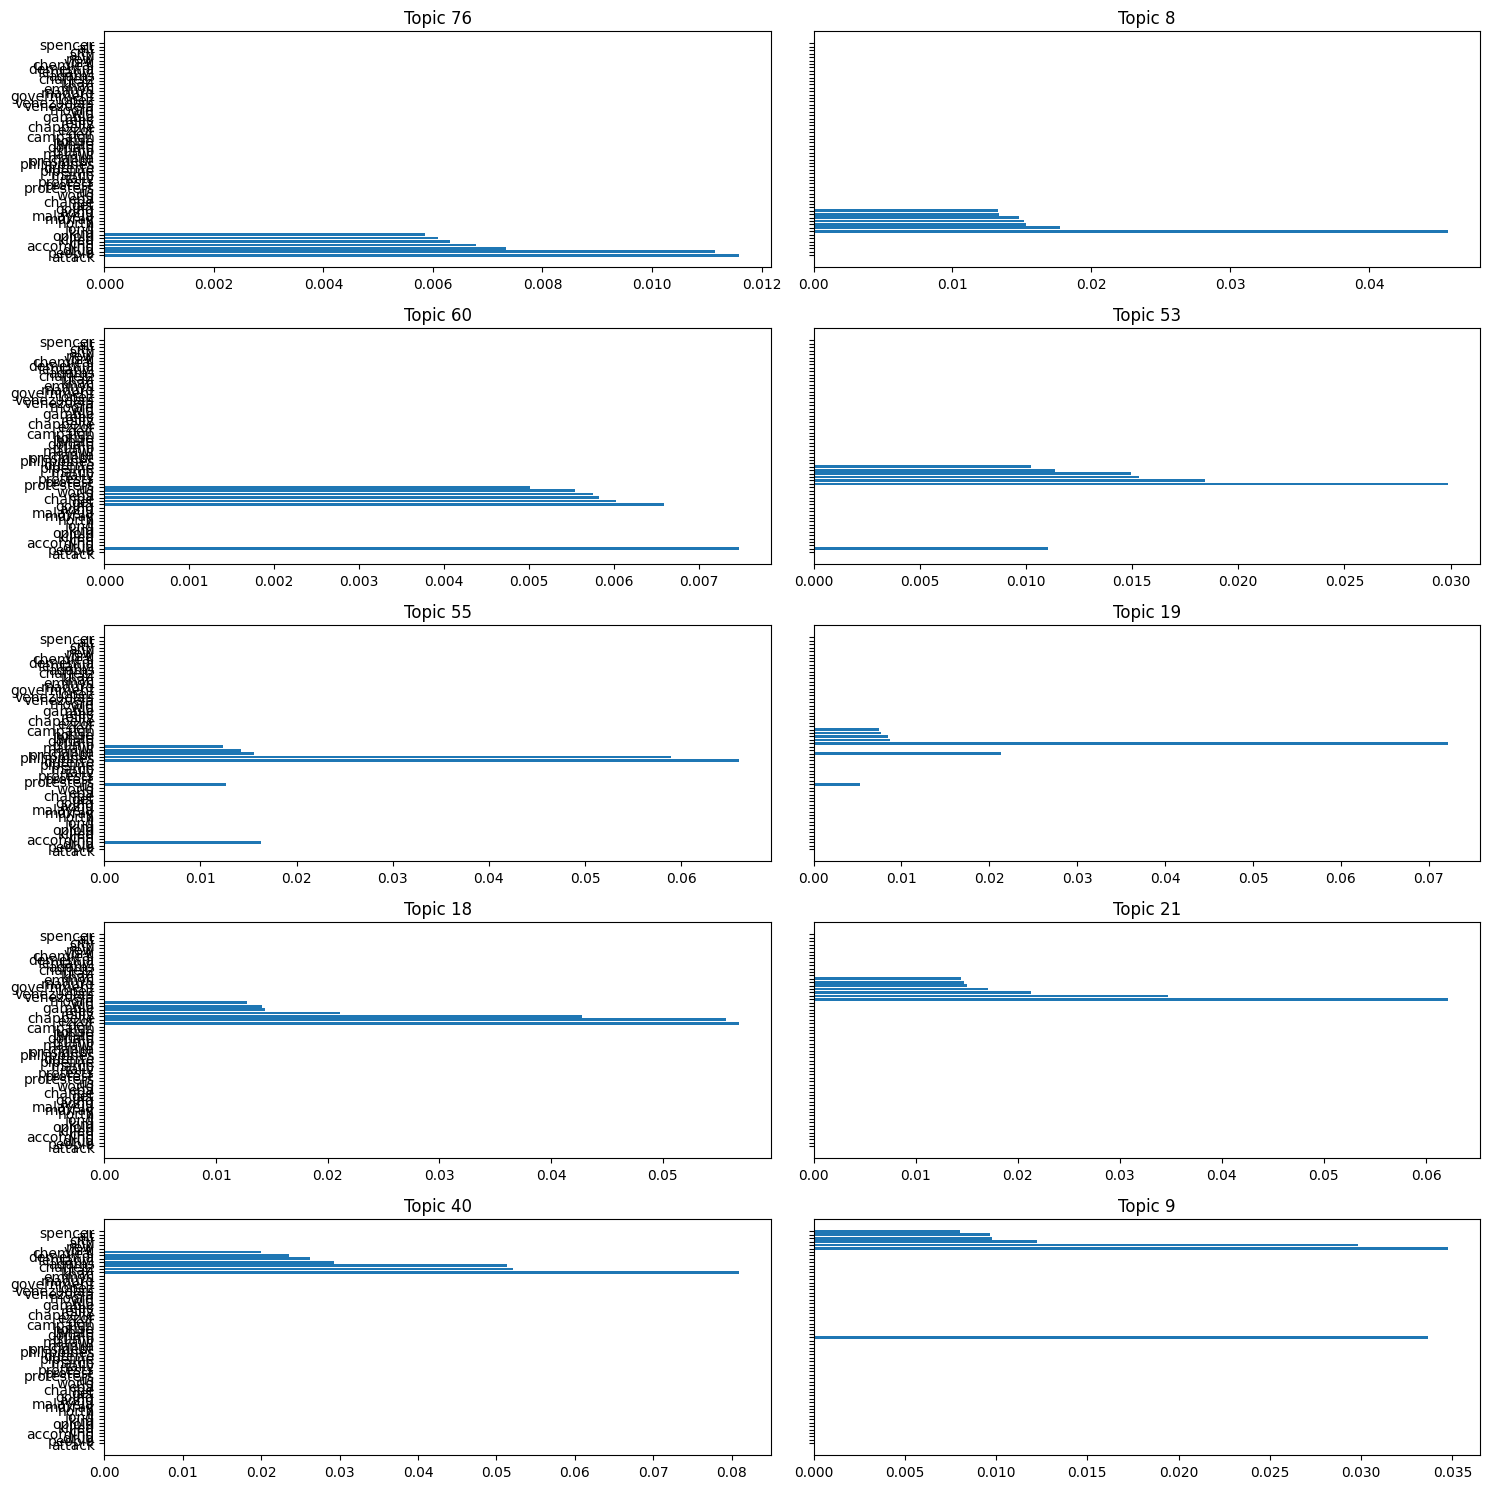

In [ ]:
### I tried a workaround because the visualization almost didn't show
### but it turned out to be very crappy
import matplotlib.pyplot as plt
# import pandas as pd

# Retrieve the top words for the first ten topics
top_topics = lda_model.show_topics(num_topics=10, num_words=7, formatted=False)

# Set up the plot
fig, axes = plt.subplots(5, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Plotting each topic
for ax, topic in zip(axes, top_topics):
    topic_num, topic_words = topic
    words, scores = zip(*topic_words)
    ax.barh(words, scores)
    ax.set_title(f'Topic {topic_num}')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
## Now I do the example using BERTopic
# data_cnn = cnn_df["text"].values.tolist()
model_cnn =  BERTopic(calculate_probabilities=True, nr_topics=100)
topics_cnn, probs_cnn = model_cnn.fit_transform(data_cnn)

In [ ]:
model_cnn.get_topic_info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,5069,-1_trump_president_people_new,"[trump, president, people, new, us, house, tim...",[trump often says least racist person trump ma...
1,0,1313,0_bill_care_republicans_obamacare,"[bill, care, republicans, obamacare, senate, r...",[health care failure plan suddenly appealing r...
2,1,1057,1_trump_russia_russian_president,"[trump, russia, russian, president, campaign, ...",[mounting evidence russian government supplyin...
3,2,649,2_trump_white_charlottesville_people,"[trump, white, charlottesville, people, protes...",[take look week politics august august preside...
4,3,369,3_immigration_border_immigrants_order,"[immigration, border, immigrants, order, wall,...",[high stakes battle immigration policy politic...
...,...,...,...,...,...
95,94,13,94_ski_skiing_vonn_danelle,"[ski, skiing, vonn, danelle, downhill, racers,...",[lindsey vonn mixes style speed lake louise da...
96,95,13,95_trudeau_canada_leary_canadians,"[trudeau, canada, leary, canadians, prime, can...",[canadian prime minister justin trudeau offere...
97,96,13,96_thrones_hbo_game_daenerys,"[thrones, hbo, game, daenerys, season, haringt...",[game thrones might best tv drama ever althoug...
98,97,12,97_cte_players_brain_football,"[cte, players, brain, football, nfl, disease, ...",[nfl pull plug funding cte study smith hard hi...


In [ ]:
### Visualization
barchart = model_cnn.visualize_barchart(top_n_topics=10, n_words = 7)
barchart.write_html('/content/drive/Shareddrives/PulseofPolicy_data/Visualizations/barchart_visualization.html')

In [ ]:
barchart

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
## More visualizations
clusters = model_cnn.visualize_topics()
clusters.write_html('/content/drive/Shareddrives/PulseofPolicy_data/Visualizations/clusters_vis.html')

In [ ]:
hierarchical_topics = model_cnn.hierarchical_topics(data_cnn)

In [ ]:
hierarchical = model_cnn.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
hierarchical.write_html('/content/drive/Shareddrives/PulseofPolicy_data/Visualizations/hierarchical_vis.html')

In [ ]:
#### This was a failed attempt to calculate the coherence for the results of the
#### BERTopic example but it was crappy

from gensim.corpora import Dictionary

all_topics = model_cnn.get_topics()

# For each topic, we take the top N words to create a "fake" document for that topic
top_n = 10  # Number of top words to extract for each topic
fake_docs = []
for topic_num, topic in all_topics.items():
    if topic_num == -1:  # Skipping the outlier cluster
        continue
    top_words = [word for word, _ in topic[:top_n]]
    fake_docs.append(top_words)

# Create a Gensim Dictionary and Corpus from the fake documents
dictionary = Dictionary(fake_docs)
corpus = [dictionary.doc2bow(doc) for doc in fake_docs]

# Create a "fake" LDA model that only serves to initialize the CoherenceModel
# This model is not used for any real computation here, as we only need the dictionary and corpus
fake_lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=len(all_topics)-1, random_state=42)

# Calculate the Coherence Score using c_v coherence
coherence_model = CoherenceModel(model=fake_lda_model, texts=fake_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Coherence Score:  0.2776813194151017


In [ ]:
### This new try was better...at least for the narrative

documents = pd.DataFrame({"Document": data_words_cnn,
                          "ID": range(len(data_words_cnn)),
                          "Topic": topics_cnn})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = model_cnn._preprocess_text(documents_per_topic.Document.values)


# Extract vectorizer and analyzer from BERTopic
vectorizer = model_cnn.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model_cnn.get_topic(topic)]
               for topic in range(len(set(topics_cnn))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.7876374290469184


In [ ]:
### This is an extra code I ran to help John who was
### entangled with the embeddings thingy
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df_fox_meanmax = pd.read_csv('/content/drive/Shareddrives/PulseofPolicy_data/text_cosinesimilarity_scores/df_fox_meanmax.csv')
df_fox_meanmax["means"] = df_fox_meanmax.mean(axis=1)
df_fox_meanmax["medians"] = df_fox_meanmax.median(axis=1)
df_fox_meanmax["25_percentiles"]  = df_fox_meanmax.quantile(0.25, axis=1)
df_fox_meanmax["75_percentiles"]  = df_fox_meanmax.quantile(0.75, axis=1)
df_fox_meanmax["standard_dev"] = df_fox_meanmax.std(axis=1)


df_fox_meanmax[["means", "medians", "25_percentiles","75_percentiles", "standard_dev"]]

In [ ]:
### I ran also the BERTopic for each outlet separately but
### the visualizations are not displayed
model_nyt =  BERTopic(calculate_probabilities=True)
topics_nyt, probs_nyt = model_nyt.fit_transform(data_nyt)

In [ ]:
model_nyt.get_topic_info()

In [ ]:
model_fox =  BERTopic(calculate_probabilities=True)
topics_fox, probs_fox = model_fox.fit_transform(data_fox)

In [ ]:
model_fox.get_topic_info()

In [ ]:
model_breitbart =  BERTopic(calculate_probabilities=True)
topics_breitbart, probs_breitbart = model_breitbart.fit_transform(data_breitbart)

In [ ]:
model_breitbart.get_topic_info()